If you choose the Time Series option, you will be forecasting real estate prices of various zip codes using data from Zillow Research. For this project, you will be acting as a consultant for a fictional real-estate investment firm. The firm has asked you what seems like a simple question:

What are the top 5 best zip codes for us to invest in?

This may seem like a simple question at first glance, but there's more than a little ambiguity here that you'll have to think through in order to provide a solid recommendation. Should your recommendation be focused on profit margins only? What about risk? What sort of time horizon are you predicting against? Your recommendation will need to detail your rationale and answer any sort of lingering questions like these in order to demonstrate how you define "best".

The goal of this project is to have you complete a very common real-world task in regard to time series modeling. However, real world problems often come with a significant degree of ambiguity, which requires you to use your knowledge of statistics and data science to think critically about and answer. While the main task in this project is time series modeling, that isn't the overall goal -- it is important to understand that time series modeling is a tool in your toolbox, and the forecasts it provides you are what you'll use to answer important questions.

Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), you need to start with a definition of "best investment". Consider additional metrics like risk vs. profitability, or ROI yield.

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!

# Business Understanding

Metric: ROI (Return on Investment)

In [1]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

# Data Understanding

In [2]:
# Load the data
df=pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


In [4]:
df.shape

(14723, 272)

In [5]:
# Filter for Neew York State
ny_df = df[df['State'] == 'NY']

In [6]:
ny_df.shape

(1015, 272)

In [7]:
# Basic EDA: summary statistics, data types, and city distribution
print("Basic Statistics (non-date columns):")
non_date_columns = ['RegionID', 'RegionName', 'SizeRank']
print(ny_df[non_date_columns].describe())

print("\nData Information:")
print(ny_df.info())

print("\nTop 10 Cities by Frequency:")
print(ny_df['City'].value_counts().head(10))


Basic Statistics (non-date columns):
           RegionID    RegionName      SizeRank
count   1015.000000   1015.000000   1015.000000
mean   62703.224631  12620.670936   8750.639409
std      616.009949   1318.766453   4229.903645
min    61625.000000  10011.000000      7.000000
25%    62158.500000  11568.500000   5600.000000
50%    62643.000000  12531.000000   9514.000000
75%    63261.500000  13739.500000  12464.500000
max    63822.000000  14905.000000  14718.000000

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 1015 entries, 6 to 14717
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 2.1+ MB
None

Top 10 Cities by Frequency:
City
New York      114
Islip          17
Syracuse        8
Rochester       7
Orangetown      7
Yonkers         6
Buffalo         6
Amherst         5
Clarkstown      5
Ramapo          4
Name: count, dtype: int64


In [14]:
# Check for null values
ny_df.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         1
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [15]:
# Fill nul;s with median
ny_df.fillna(method='bfill', inplace=True)

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\3925550359.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ny_df.fillna(method='bfill', inplace=True)


In [17]:
ny_df.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         1
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [21]:
ny_df.dropna()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,New York,21,3676700.0,3704200.0,3729600.0,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14645,62449,12175,Summit,NY,Albany,Schoharie,14646,60000.0,59600.0,59100.0,...,126300,126400,126600,127100,127900,128600,129100,129400,129100,128600
14663,62430,12153,Sand Lake,NY,Albany,Rensselaer,14664,95700.0,95000.0,94300.0,...,191000,191700,192000,193100,195400,198300,200500,202600,205200,207300
14693,62433,12156,Schodack,NY,Albany,Rensselaer,14694,94400.0,94600.0,94800.0,...,188600,189800,189600,190500,191100,192000,193600,196100,198000,199400
14702,62599,12480,Shandaken,NY,Kingston,Ulster,14703,70900.0,70400.0,70000.0,...,160100,160600,160500,160100,159900,159000,157000,157700,161000,163700


In [9]:
# rename columns
df = df.rename(columns={'RegionName': 'Zipcode'})

In [23]:
print("Basic Statistics (non-date columns):")
print(ny_df[['RegionID', 'RegionName', 'SizeRank']].describe())
print("\nData Information:")
print(ny_df.info())
print("\nTop 10 Cities by Frequency:")
print(ny_df['City'].value_counts().head(10))

Basic Statistics (non-date columns):
           RegionID    RegionName      SizeRank
count   1015.000000   1015.000000   1015.000000
mean   62703.224631  12620.670936   8750.639409
std      616.009949   1318.766453   4229.903645
min    61625.000000  10011.000000      7.000000
25%    62158.500000  11568.500000   5600.000000
50%    62643.000000  12531.000000   9514.000000
75%    63261.500000  13739.500000  12464.500000
max    63822.000000  14905.000000  14718.000000

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 1015 entries, 6 to 14717
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 2.1+ MB
None

Top 10 Cities by Frequency:
City
New York      114
Islip          17
Syracuse        8
Rochester       7
Orangetown      7
Yonkers         6
Buffalo         6
Amherst         5
Clarkstown      5
Ramapo          4
Name: count, dtype: int64


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


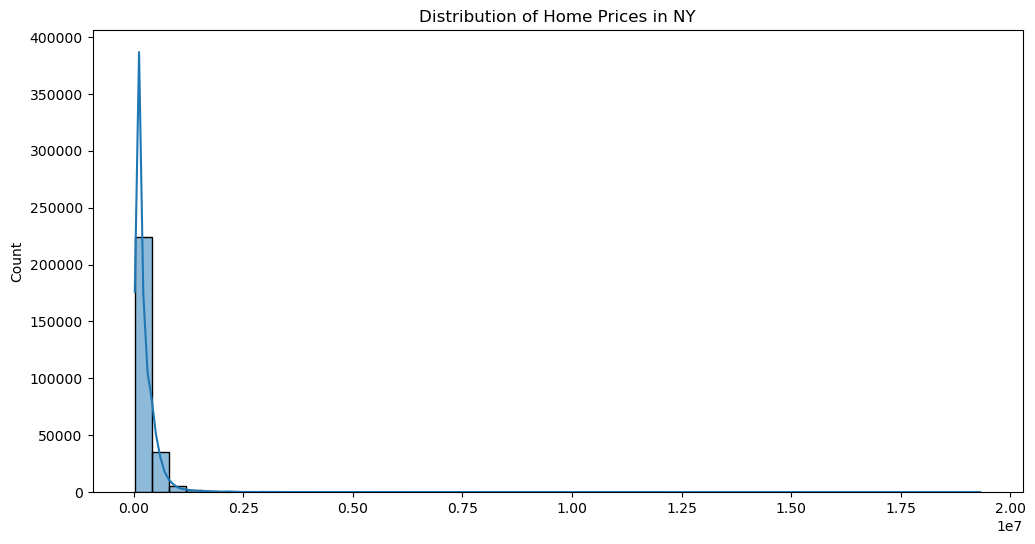

In [25]:
# Visualization: Distribution of home prices
plt.figure(figsize=(12, 6))
sns.histplot(ny_df.iloc[:, 7:].stack(), bins=50, kde=True)
plt.title('Distribution of Home Prices in NY')
plt.show()

In [27]:
nyc_df = df[df['City'] == 'New York']

In [32]:
nyc_df.Zipcode.value_counts()

Zipcode
10467    1
11360    1
11419    1
11421    1
11378    1
        ..
11203    1
11368    1
11219    1
11204    1
10464    1
Name: count, Length: 114, dtype: int64

In [33]:
# Convert dates to datetime objects
def get_datetimes(df):
    """
    Takes a dataframe:
    Returns only those column names that can be converted into datetime objects
    as datetime objects.
    """
    date_columns = [col for col in df.columns if pd.to_datetime(col, format='%Y-%m', errors='coerce') is not pd.NaT]
    return pd.to_datetime(date_columns, format='%Y-%m')

# Run the function
datetime_columns = get_datetimes(ny_df)
print(datetime_columns)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)


In [34]:
dates = [col for col in nyc_df.columns if col not in ['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']]

In [35]:
top_5_zips = nyc_df.sort_values(by='SizeRank').head(5)

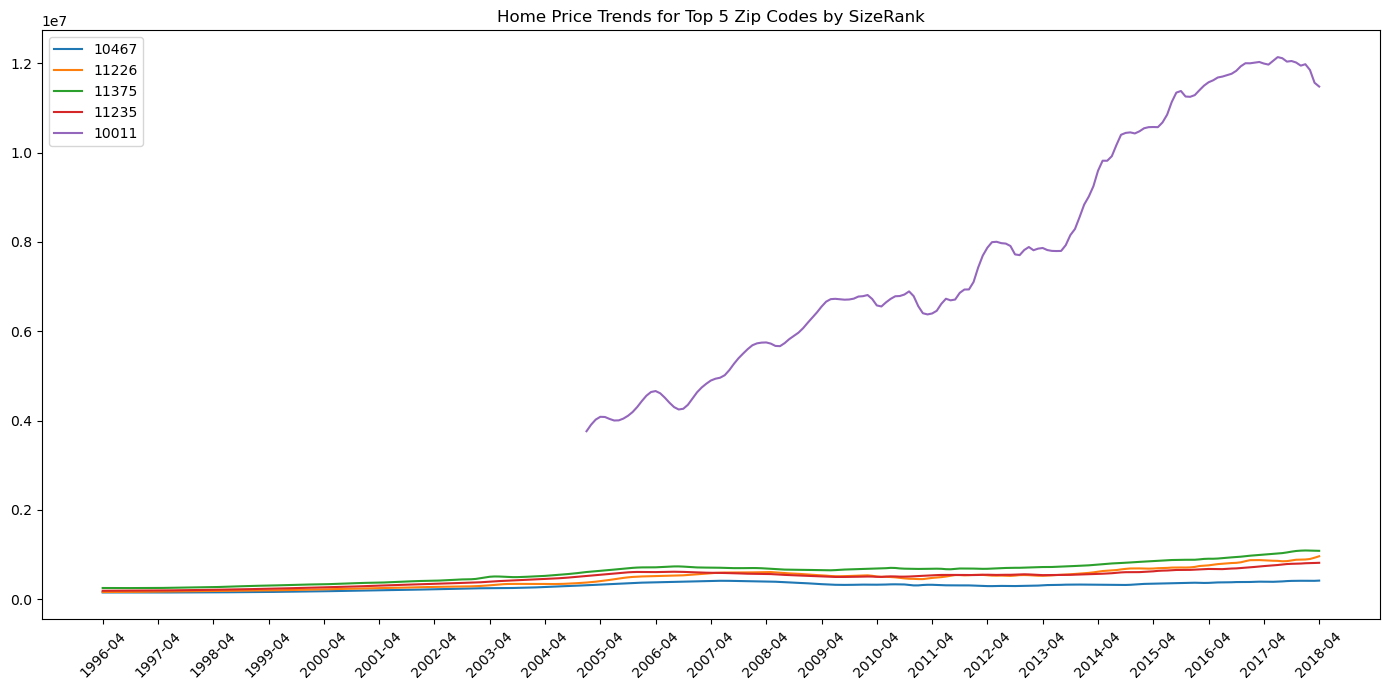

In [38]:
plt.figure(figsize=(14, 7))
for _, row in top_5_zips.iterrows():
    plt.plot(dates, row[dates].values, label=row['Zipcode'])  # Ensure 'Zipcode' matches your column name

plt.title('Home Price Trends for Top 5 Zip Codes by SizeRank')
plt.legend()

# Improve x-axis labels
plt.xticks(ticks=range(0, len(dates), 12), labels=[dates[i] for i in range(0, len(dates), 12)], rotation=45)
plt.tight_layout()  # Ensure nothing overlaps
plt.show()

In [41]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['Zipcode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [43]:
ts=melt_data(nyc_df)

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)


In [47]:
# Check if stationary data using the Dickey-Fuller Test

def display_df (dftest):
    '''
    Display the ouput from a Dickey-Fuller test in a more readable format
    '''
    
    dfoutput=pd.Series(
    dftest[0:4],
    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    display(dfoutput)

# Modeling

## Check if Data is Stationary

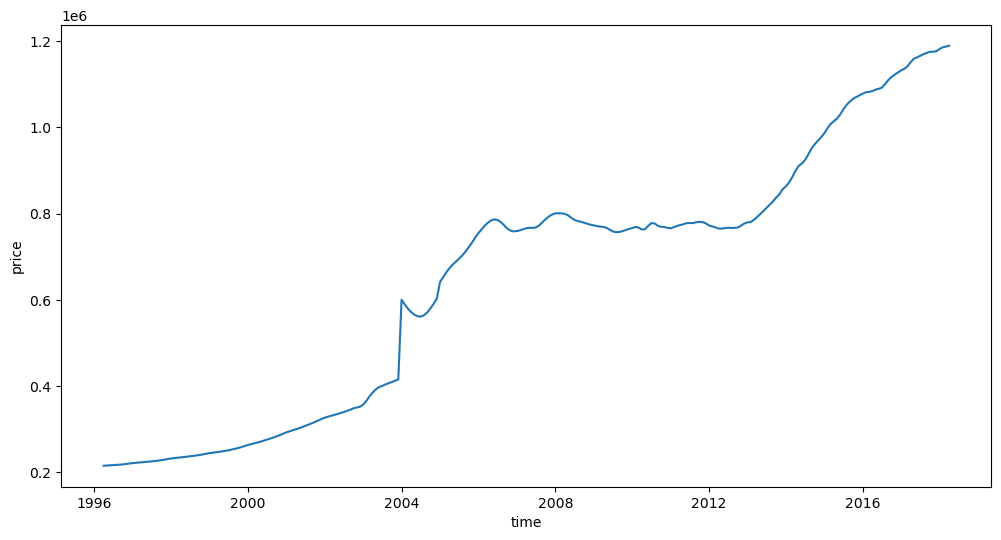

<Figure size 640x480 with 0 Axes>

In [48]:
fig=plt.figure(figsize=(12,6))
plt.plot(ts)
plt.xlabel('time')
plt.ylabel('price')
plt.show()
plt.gcf().autofmt_xdate()

In [50]:
# Dickey-Fuller
dftest=adfuller(ts)

In [70]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(ts)

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
ts_diff = ts.diff()
    
# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(ts_diff.dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.") 

ADF Statistic (Original): 0.5733
p-value (Original): 0.9869
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -15.2691
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


In [71]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(data.index, result, label='Differenced Close Price', color='orange')
plt.title('Home Prices over Time')
plt.xlabel('Date')
plt.ylabel('Home Price')
plt.legend()
plt.show()

NameError: name 'data' is not defined

<Figure size 1400x700 with 0 Axes>

In [57]:
# Initialize dictionaries to store ROI forecasts
forecasts_arima = {}
forecasts_sarima = {}

In [59]:
# Iterate through each zip code and model using ARIMA and SARIMA
for zip_code in ny_df['Zipcode'].unique():
    zip_data = ny_df[ny_df['Zipcode'] == zip_code]
    melted_data = melt_data(zip_data)    
    
    # Ensure there is enough data for time series modeling
    if len(melted_data) < 24:
        continue


C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict ver

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict ver

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict ver

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
C:\Users\hrcoh\AppData\Local\Temp\ipykernel_32248\268462306.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict ver

In [60]:
# Make data stationary
stationary_data, d = make_stationary(melted_data['value'])

In [61]:
dftest=adfuller(melted_data)
display_df(dftest)

Test Statistic                  -2.002425
p-value                          0.285511
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64

# Step 5: ARIMA Modeling

In [ ]:
# Split data into train and test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:])

## Testing

In [ ]:
y_hat_test = aa_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test)
plt.xticks(rotation = 45, ha='right');

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test)
plt.xticks(rotation = 45, ha='right');

In [ ]:
np.sqrt(mean_squared_error(test, y_hat_test))

In [ ]:
plot_acf(ts_log_decompose);

In [ ]:
plot_acf(ts_log_decompose, lags=75);

## SARIMA

In [ ]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

In [ ]:
sari_mod =SARIMAX(train,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

In [ ]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

In [ ]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [ ]:
np.sqrt(mean_squared_error(test, y_hat_test))

## Forecast

In [ ]:
sari_mod = SARIMAX(ts_weekly,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
forecast = sari_mod.forecast(steps=52)

In [ ]:
fig, ax = plt.subplots()
ax.plot(ts_weekly, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Chicago Gun Crime Predictions\n One Year out')

plt.legend();

# Step 6: Interpreting Results